<a href="https://colab.research.google.com/github/Klein225/Option-Pricing-Using-Neural-Networks/blob/master/European_Call_in_Black_%26_Scholes_(McGhee_Final)_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Europen Call in Black-Scholes-Merton (Partially McGhee)**
### **Version 2: The ability to freely choose the number of neurons and layers**
We will try and learn the BSM Model (without dividends) using a Neural Network with the same (almost) parameters as in McGhees paper "An Artificual Neural Network Representation of the SABR Stochastic Volatility Model". This is intended as a introduction to the more complex SABR model which is an extension of the BSM model.

We will start by creatin a dataset for us to train on

In [0]:
# Import packages
import pylab
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#N: number of random options
N = 100000

#Make the same random numbers every time using seed
random.seed(42)

#uniform stock pices
S = np.random.rand(N) * 100
#Stike prices (simpler version of how McGhee chooses his strike prices)
K = (np.random.randint(50, 150, N) * .01) * S
#Time (1day to 2 years)
T = np.random.randint(1, 730, N) / 365
#Risk free rate
r = np.random.randint(1, 500, N) / 10000
#volatility (5% to 50%)
sigma = np.random.randint(5, 50, N) / 100

In [0]:
Option_values = pd.DataFrame({'S': S,
                              'K': K,
                              'T': T,
                              'r': r,
                              'sigma': sigma})

In [0]:
Option_values.tail()

,S,K,T,r,sigma
99995,81.483893,78.224537,1.164384,0.0268,0.14
99996,7.345389,4.554141,1.758904,0.0396,0.08
99997,69.624174,52.914372,0.745205,0.0305,0.33
99998,10.011838,11.313377,1.386301,0.0186,0.41
99999,25.336562,35.217822,1.084932,0.0311,0.09


**<h3><center>Black & Scholes' formula</center></h3>**

Since we are using supervised learning, we need to calculate the BSM call prices. this is done using the following formula:
$$
B{S_{K,T,\sigma }}\left( S \right) = SN\left( {\frac{{\log \left( {\frac{S}{K}} \right) +\left( r+ \frac{{{\sigma ^2}}}{2}\right)T}}{\sigma \sqrt{T} }} \right) - Ke^{-rT}N\left( {\frac{{\log \left( {\frac{S}{K}} \right) +\left( r- \frac{{{\sigma ^2}}}{2}\right)T}}{\sigma\sqrt{T} }} \right)
$$

In [0]:
def bsm_call(S, K, T, r, sigma):
  d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
  d2 = (np.log(S / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))

  return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

In [0]:
#Generate option prices for all the random option values
%%time

Option_prices = []
for i in range(N):
  C = bsm_call(S[i], K[i], T[i], r[i], sigma[i])
  Option_prices.append(C)
  #print how far its gotten at regular intervals
  if (i % 10000) == 0:
    print('Generated {} options'.format(i))

Options = pd.DataFrame({'S': S,
                        'K': K,
                        'T': T,
                        'r': r,
                        'sigma': sigma,
                        'C': Option_prices})

Generated 0 options
Generated 10000 options
Generated 20000 options
Generated 30000 options
Generated 40000 options
Generated 50000 options
Generated 60000 options
Generated 70000 options
Generated 80000 options
Generated 90000 options
CPU times: user 19.3 s, sys: 231 ms, total: 19.6 s
Wall time: 19.2 s


In [0]:
Options.tail()

,S,K,T,r,sigma,C
99995,81.483893,78.224537,1.164384,0.0268,0.14,8.094081
99996,7.345389,4.554141,1.758904,0.0396,0.08,3.097661
99997,69.624174,52.914372,0.745205,0.0305,0.33,19.201472
99998,10.011838,11.313377,1.386301,0.0186,0.41,1.538544
99999,25.336562,35.217822,1.084932,0.0311,0.09,0.000606


Lets check the distribution of the different input values and the target output 

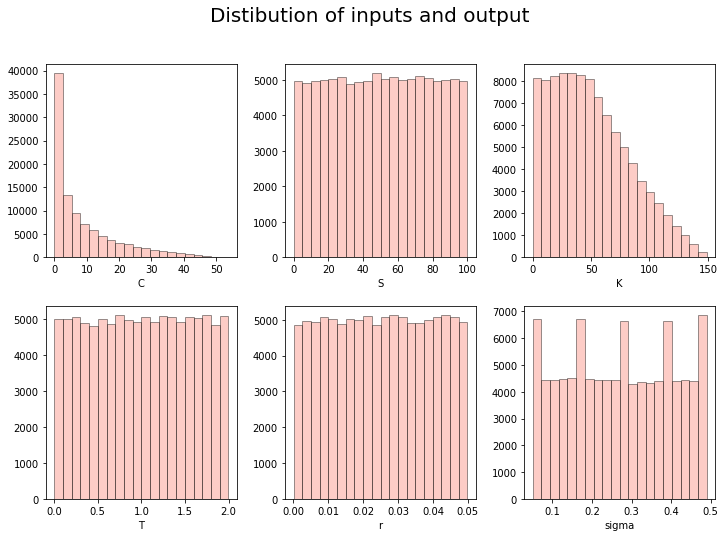

In [0]:
fig, ax =plt.subplots(2,3, figsize=(12,8))
fig.subplots_adjust(wspace = 0.25, hspace = 0.25)
fig.suptitle('Distibution of inputs and output', fontsize=20)

sns.distplot(Options['C'], hist=True, kde=False,
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[0,0]);
sns.distplot(Options['S'], hist=True, kde=False, 
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[0,1]);
sns.distplot(Options['K'], hist=True, kde=False, 
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[0,2]);
sns.distplot(Options['T'], hist=True, kde=False, 
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[1,0]);
sns.distplot(Options['r'], hist=True, kde=False, 
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[1,1]);
sns.distplot(Options['sigma'], hist=True, kde=False, 
             bins=int(20), color = 'salmon',
             hist_kws={'edgecolor':'black'}, ax=ax[1,2]);                                                   


#fig.title('MSE of Neural Network', fontsize=20,)
fig.show()

**<h3><center>A simple Neural Network</center></h3>**
We will now start training our neural network on the BSM call prices. Just as in McGhees paper, we will use the following:
*   Hidden layers: 1 - 3

Given the universal approximation theorem we should in priciple be able to get away with only one hidden layer to approximate any continous function under certain assumptions. 

*   Nodes / Neurons: 1 - 

You can try increasing the number of neurons gradually untill the network starts overfitting. But in practice, it's often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting.

*   Optimizer: Adam

Adam, which stands for "adaptive moment estimation". It keeps track of an exponentially  decaying  average of past gradients and keeps track of an exponentially decaying average of past squared gradients.

*   Loss function: Mean squared error

MSE i current best practice, and good for fast calculations as it is a part of the official Keras API. It is also good when you dont have too many outliers.

*   Activation function: Softplus

Softplus activation function is a smooth variant of Relu (both ensures a positive output value):
$$
f(z)=\ln(e^z+1)
$$
It is close to 0 when $z$ is negative and close to $z$ when $z$ is positive.

We start by splitting our data into a training, testing set and a validation set. We do this in order to avoid too much overfitting.

In [0]:
#For us to use the Sklearn model "train_test_split" we need to make a dataframe into a numpy array
call_options = Options.values 

#First split the input variable and output variable from each other
#input values
X = call_options[:, :5]
#output values
y = call_options[:, 5:6]

# 60% for training, 10% for testing and 20% for validating
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

#We standardize our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(70000, 5) (70000, 1)
(20000, 5) (20000, 1)
(10000, 5) (10000, 1)


Now, lets build the neural network with one hidden layer consisting of 1000 neurons/nodes and one output layer with 1 neuron/node.

In [0]:
def number_of_layers_neurons(Layers, Neurons):
  #make model a global variable so we can call it outside the function
  global model, history
  
  #build the model given a number of layers
  if Layers == 1:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation='softplus', input_shape=X_train.shape[1:]),
    #Output layer
    keras.layers.Dense(1)
    ])
  elif Layers == 2:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation='softplus', input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation='softplus'),
    #Output layer
    keras.layers.Dense(1)
    ])

  elif Layers == 3:
    model = keras.models.Sequential([
    #Hidden layer 1
    keras.layers.Dense(Neurons, activation='softplus', input_shape=X_train.shape[1:]),
    #Hidden layer 2
    keras.layers.Dense(Neurons, activation='softplus'),
    #Hidden layer 3
    keras.layers.Dense(Neurons, activation='softplus'),
    #Output layer
    keras.layers.Dense(1)
    ])
  else:
    print("Invalid amount of Layers! Choose 1-3")
    return
  
  #compile the model
  model.compile(loss="mean_squared_error",
                optimizer="adam")

  #Stop training if cost function (val_loss) using cross validation data fails to decrease.
  callbacks_list = EarlyStopping(monitor = 'val_loss', patience = 3)

  #train the model
  history = model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      verbose = 2, 
                      callbacks=[callbacks_list])

Run our neural network with Layers:1-3, and the number of neurons of own choice

In [0]:
%%time

layers = 2
neurons = 500

number_of_layers_neurons(Layers=layers, Neurons=neurons)

Epoch 1/100
2188/2188 - 9s - loss: 9.6675 - val_loss: 1.0294
Epoch 2/100
2188/2188 - 10s - loss: 0.5213 - val_loss: 0.2582
Epoch 3/100
2188/2188 - 9s - loss: 0.1917 - val_loss: 0.2332
Epoch 4/100
2188/2188 - 10s - loss: 0.1138 - val_loss: 0.0770
Epoch 5/100
2188/2188 - 10s - loss: 0.0694 - val_loss: 0.0668
Epoch 6/100
2188/2188 - 9s - loss: 0.0521 - val_loss: 0.0414
Epoch 7/100
2188/2188 - 10s - loss: 0.0414 - val_loss: 0.0429
Epoch 8/100
2188/2188 - 9s - loss: 0.0372 - val_loss: 0.0252
Epoch 9/100
2188/2188 - 9s - loss: 0.0337 - val_loss: 0.0201
Epoch 10/100
2188/2188 - 9s - loss: 0.0283 - val_loss: 0.0282
Epoch 11/100
2188/2188 - 9s - loss: 0.0269 - val_loss: 0.0334
Epoch 12/100
2188/2188 - 9s - loss: 0.0235 - val_loss: 0.0164
Epoch 13/100
2188/2188 - 9s - loss: 0.0219 - val_loss: 0.0305
Epoch 14/100
2188/2188 - 9s - loss: 0.0220 - val_loss: 0.0138
Epoch 15/100
2188/2188 - 9s - loss: 0.0197 - val_loss: 0.0262
Epoch 16/100
2188/2188 - 9s - loss: 0.0198 - val_loss: 0.0166
Epoch 17/100


In [0]:
#If you want to check that it indeed does have the descired amount of layers and neurons
#model.summary()

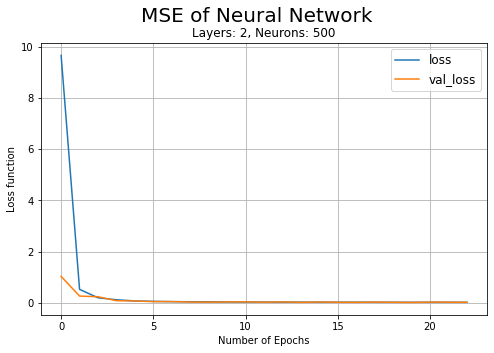

In [0]:
def plot():
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss function')
  plt.suptitle('MSE of Neural Network', fontsize=20)
  plt.title('Layers: {}, Neurons: {}'.format(layers,neurons))
  plt.legend(loc="upper right", fontsize=12)
  #plt.axis([0, 100, 0, 25])
  plt.show()  

plot()

Once we are satisfied with your models validation loss, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production.

In [0]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0135


0.013536026701331139